TITLE:
Predicting whether fasting blood sugar level is higher than 120mg in an individual using age and serum cholestrol levels.

INTRODUCTION: 
My topic is on predicting whether a person has fasting blood sugar higher than 120mg using the variables age and serum cholestrol.

Therefore, my question is "can increasing age and serum cholestrol predict whether an individual has a fasting blood sugar level higher than 120mg/dL using the Cleveland database?". 

In [48]:
library(tidyverse)
library(cowplot)
library(scales)
library(readr)
library(repr)
library(tidymodels)

PRELIMINARY EXPLORATORY ANALYSIS and METHODS: 

First, I will load the data using the shortest relative path from the cleveland data.

In [49]:
training_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
head(training_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Secondly, I select and rename the columns X1, X5, X6 to "age", "cholestoral", and "fasting_blood_sugar". After filtering ages over 55, I chaned the fasting_blood_sugar column data type such that it is categorical.

In [50]:
selected_data <- training_data |>
    rename(age = X1, cholesterol = X5, fasting_blood_sugar = X6) |>
     select(fasting_blood_sugar, cholesterol, age) |>
    filter(age > 55, cholesterol > 300) |>
    mutate(fasting_blood_sugar = as_factor(fasting_blood_sugar)) 
head(selected_data)

fasting_blood_sugar,cholesterol,age
<fct>,<dbl>,<dbl>
0,354,57
0,340,58
0,335,64
0,302,71
0,330,61
1,417,65


I recoded the variable's name to "over" from "1" to indicate that blood sugar level is over 120mg/dL and "below" from "0" to indicate blood sugar level lower than 120mg/dL.

In [51]:
mutated_data <- selected_data |>
    mutate(fasting_blood_sugar = recode(fasting_blood_sugar, "1" = "over", "0" = "below"))
head(mutated_data)

fasting_blood_sugar,cholesterol,age
<fct>,<dbl>,<dbl>
below,354,57
below,340,58
below,335,64
below,302,71
below,330,61
over,417,65


Finally, I specified for 75% of the training data and 25% for the testing data to build our model.

In [52]:

set.seed(3456) 
cleveland_split <- initial_split(mutated_data, prop = 0.75, strata = fasting_blood_sugar)  
cleveland_train<- training(cleveland_split)   
cleveland_test<- testing(cleveland_split)


Next, I made a table that reports the number of observations in each variable (over and below) in the fasting blood sugar column for both age and cholestoral levels separately. Then, I summarized the number of observations of blood sugar levels. 

In [53]:
cleveland_table <- cleveland_train |>
        group_by(age) |>
        summarize(
    over = sum(fasting_blood_sugar == "over"),
    below = sum(fasting_blood_sugar == "below"))
cleveland_table

age,over,below
<dbl>,<int>,<int>
56,0,1
57,0,1
58,1,1
59,0,1
60,0,2
61,0,2
62,0,1
63,0,1
64,0,4


In [54]:
cleveland_table_2 <- cleveland_train |>
        group_by(cholesterol) |>
        summarize(
    over = sum(fasting_blood_sugar == "over"),
    below = sum(fasting_blood_sugar == "below"))
cleveland_table_2

cholesterol,over,below
<dbl>,<int>,<int>
302,0,1
305,0,1
307,0,1
309,0,1
313,0,1
318,0,2
319,1,0
322,0,1
325,0,1


Finally, here is the scatter plot to show the predictor's relationship and to see the distribution of fasting blood sugar levels.

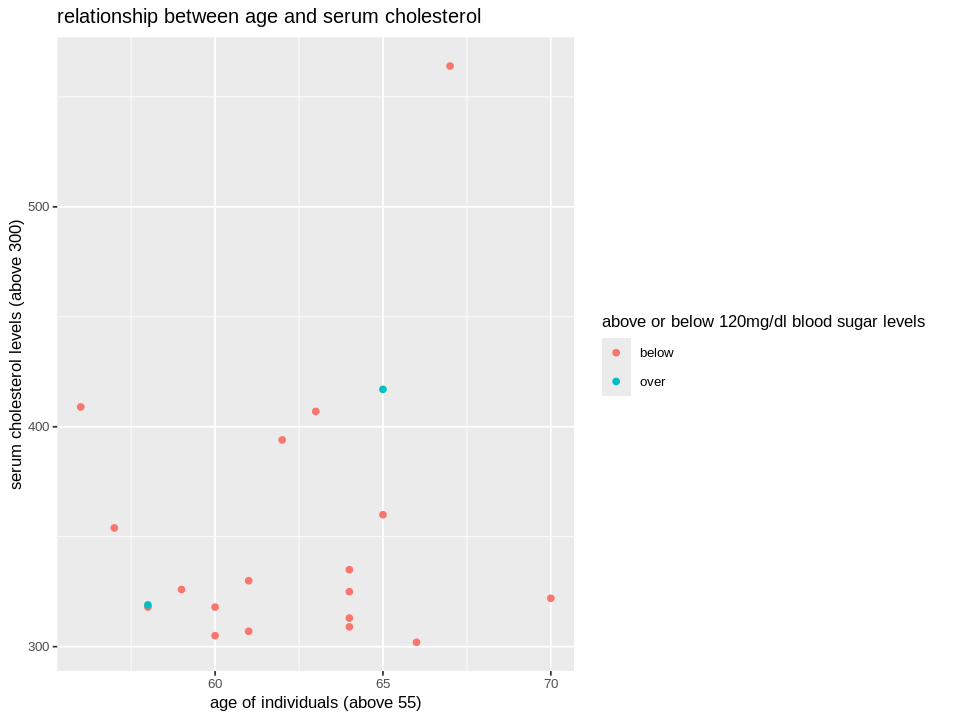

In [56]:
options(repr.plot.height = 6, repr.plot.width = 8)
cleveland_plot <- cleveland_train |>
        ggplot(aes ( x = age , y = cholesterol, colour = fasting_blood_sugar)) +
        geom_point() +
        labs(x = "age of individuals (above 55)", 
        y = "serum cholesterol levels (above 300)", 
             colour = "above or below 120mg/dl blood sugar levels") +
        ggtitle("relationship between age and serum cholesterol") +
    theme(text = element_text(size = 10))
cleveland_plot

I will then conduct my data analysis further using the K nearest neighbors classification. Firstly, I will pick the value of K that gives me the best accuracy to improve the classifier by using tune() on our validation data set. Then, by collecting the metrics, I can plot K vs accuracy and choose the K value with the highest accuracy. Once I complete the 5 fold cross-validation, I can build my model using recipe, fit, and workflow using the training_data. Finally, I can use my model to predict my new observation on the test dataset. Then, we can also discover if there is a relationship between age, serum cholesterol levels and fasting blood levels (risk of diabetes). To conclude, I will find my classifier's accuracy, precision and recall using the metrics function and confusion matrix.

EXPECTED OUTCOMES AND SIGNIFICANCE: 

I expect that higher age and serum cholesterol levels will increase the risk of elevated fasting blood levels, thus the classifer will predict "fasting blood level higher than 120mg/dl". Although this project's finding should not be used to diagnose an individual, we could inform and enhance preventative care. For instance, we can develop health programs to enhance exercise for people with high cholesterol levels and age. Also, these findings can help guide further research by providing a basis with our classifier and potentially leading to new treatment approaches. My findings could lead to more questions that delve deeper; can my age and serum cholesterol levels predict the specific type of diabetes? Are there any differences in the relationship between age, cholesterol, and blood sugar levels among different demographic groups?